# Importing libraries

In [1]:
!pip install haversine

In [2]:
import numpy as np
import pandas as pd
import math as m
from haversine import haversine, Unit
import seaborn as sns
import matplotlib.pyplot as plt

# Data exploration

In [3]:
url='https://github.com/mokhatib123/123123123/raw/main/uber123.csv'

In [4]:
df = pd.read_csv(url)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [6]:
df.sample(1000).head(5)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
20343,51050382,08:00.0,6.9,2010-11-10 18:08:00 UTC,-73.977920,40.736715,-73.976542,40.751657,1
191979,21668246,09:00.0,18.5,2014-05-31 04:09:00 UTC,-73.959797,40.710792,-73.973470,40.668672,1
3020,21357195,36:00.0,5.3,2011-08-31 20:36:00 UTC,-73.968735,40.770122,-73.956523,40.783875,1
151097,38621114,52:05.0,5.5,2015-01-14 20:52:05 UTC,-73.980377,40.752628,-73.978012,40.742401,1
35793,42363509,31:52.0,12.5,2015-03-20 07:31:52 UTC,-73.964416,40.803310,-73.956581,40.775661,1


# Data cleaning and prep

In [7]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         199999 non-null  int64  
 1   key                199999 non-null  object 
 2   fare_amount        199999 non-null  float64
 3   pickup_datetime    199999 non-null  object 
 4   pickup_longitude   199999 non-null  float64
 5   pickup_latitude    199999 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 15.3+ MB


In [8]:
df['fare_amount'].describe()

count    199999.000000
mean         11.359892
std           9.901760
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

In [9]:
#drop outliers
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3-Q1
upper_bound = Q3 + 1.5 * IQR

df = df[(df['fare_amount'] < upper_bound)]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182844 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         182844 non-null  int64  
 1   key                182844 non-null  object 
 2   fare_amount        182844 non-null  float64
 3   pickup_datetime    182844 non-null  object 
 4   pickup_longitude   182844 non-null  float64
 5   pickup_latitude    182844 non-null  float64
 6   dropoff_longitude  182844 non-null  float64
 7   dropoff_latitude   182844 non-null  float64
 8   passenger_count    182844 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.9+ MB


In [11]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.828440e+05,182844.000000,182844.000000,182844.000000,182844.000000,182844.000000,182844.000000
mean,2.770842e+07,8.938086,-72.545485,39.949196,-72.545502,39.936443,1.681504
std,1.600963e+07,4.154328,11.366187,7.799834,13.293971,6.791340,1.391814
min,1.000000e+00,-52.000000,-1340.648410,-74.009697,-3356.666300,-881.985513,0.000000
25%,1.382177e+07,5.700000,-73.992356,40.735718,-73.991660,40.735287,1.000000
50%,2.774600e+07,8.000000,-73.982242,40.752542,-73.980832,40.753202,1.000000
75%,4.154048e+07,11.000000,-73.969055,40.766500,-73.966670,40.767383,2.000000
max,5.542357e+07,22.200000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [12]:
#drop columns where coordinates are invalid
cond1 = ((df.pickup_longitude >= -180) & (df.pickup_longitude <= 180)) & ((df.dropoff_longitude >= -180) & (df.dropoff_longitude <= 180))
cond2 = ((df.pickup_latitude >= -90) & (df.pickup_latitude <= 90)) & ((df.dropoff_latitude >= -90) & (df.dropoff_latitude <= 90))
df = df[(cond1 & cond2)]

In [13]:
#feature transformation
def haversine_distance(row):
    coords_1 = (row['pickup_latitude'], row['pickup_longitude'])
    coords_2 = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(coords_1, coords_2, unit=Unit.KILOMETERS)


df['distance_traveled'] = df.apply(haversine_distance, axis=1)

In [14]:
#drop distance outliers
Q1 = df['distance_traveled'].quantile(0.25)
Q3 = df['distance_traveled'].quantile(0.75)
IQR = Q3-Q1
upper_bound = Q3 + 1.5 * IQR

df = df[(df['distance_traveled'] < upper_bound)]

In [15]:
#dropping rows where distance is 0
df = df[(df['distance_traveled'] != 0)]

<Axes: >

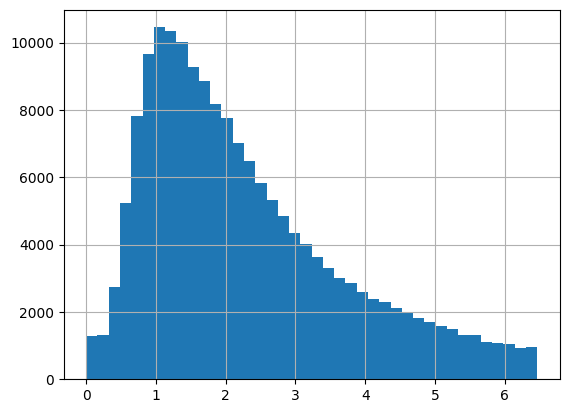

In [16]:
df['distance_traveled'].hist(bins = 40)

In [17]:
print(df.corr())

                   Unnamed: 0  fare_amount  pickup_longitude  pickup_latitude  \
Unnamed: 0           1.000000    -0.001879          0.001589        -0.001934   
fare_amount         -0.001879     1.000000          0.002575        -0.003409   
pickup_longitude     0.001589     0.002575          1.000000        -0.993511   
pickup_latitude     -0.001934    -0.003409         -0.993511         1.000000   
dropoff_longitude    0.001613     0.003004          0.999976        -0.993524   
dropoff_latitude    -0.001948    -0.003764         -0.993516         0.999968   
passenger_count      0.003143     0.017017          0.009062        -0.009319   
distance_traveled   -0.002048     0.793308         -0.013741         0.012116   

                   dropoff_longitude  dropoff_latitude  passenger_count  \
Unnamed: 0                  0.001613         -0.001948         0.003143   
fare_amount                 0.003004         -0.003764         0.017017   
pickup_longitude            0.999976         

<ipython-input-17-23236a4e6045>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())


In [18]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['month']=df['pickup_datetime'].dt.month
df['hour']=df['pickup_datetime'].dt.hour

In [19]:
print(df.dtypes)

Unnamed: 0                         int64
key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
distance_traveled                float64
month                              int64
hour                               int64
dtype: object


In [20]:
df.drop(['Unnamed: 0','key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1, inplace = True)

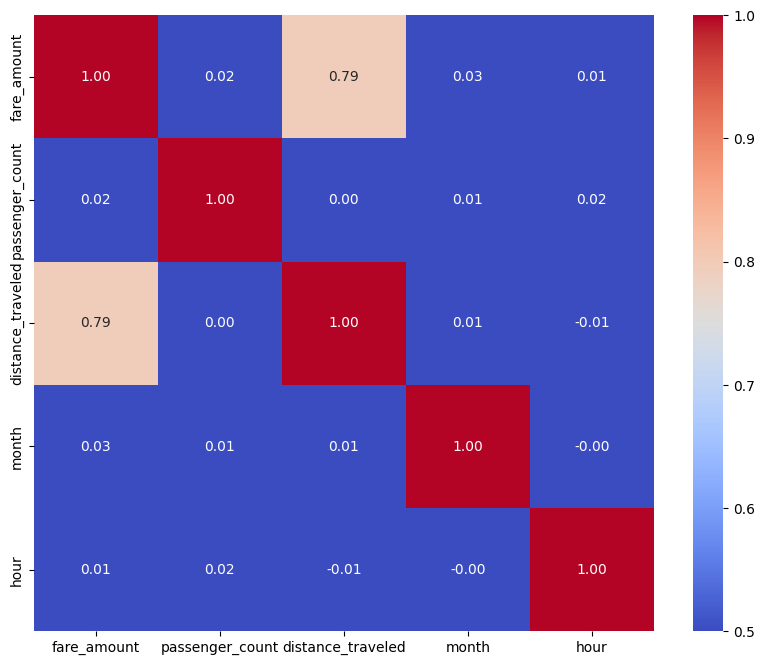

In [21]:

correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=0.5)
plt.show()

In [22]:

df['month'] = df['month'].astype(str)
df['hour'] = df['hour'].astype(str)


df_encoded = pd.get_dummies(df, columns=['month', 'hour'])


In [23]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169414 entries, 0 to 199999
Data columns (total 39 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        169414 non-null  float64
 1   passenger_count    169414 non-null  int64  
 2   distance_traveled  169414 non-null  float64
 3   month_1            169414 non-null  uint8  
 4   month_10           169414 non-null  uint8  
 5   month_11           169414 non-null  uint8  
 6   month_12           169414 non-null  uint8  
 7   month_2            169414 non-null  uint8  
 8   month_3            169414 non-null  uint8  
 9   month_4            169414 non-null  uint8  
 10  month_5            169414 non-null  uint8  
 11  month_6            169414 non-null  uint8  
 12  month_7            169414 non-null  uint8  
 13  month_8            169414 non-null  uint8  
 14  month_9            169414 non-null  uint8  
 15  hour_0             169414 non-null  uint8  
 16  ho

# Building Model

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


X = df_encoded.drop('fare_amount', axis=1)
y = df_encoded['fare_amount']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 4.963550768048581
R-squared: 0.6458263665217735


In [31]:

tolerance = 2

within_tolerance = sum(abs(y_pred - y_test) <= tolerance)
accuracy = within_tolerance / len(y_test)

print(f'Accuracy within {tolerance} units: {accuracy * 100:.2f}%')


Accuracy within 2 units: 74.11%


# Applying Model

In [32]:
def uberrideprediction(distance, passengers, pickupdatetime, model, scaler, df_train):
    input_data = pd.DataFrame({
        'distance': [distance],
        'passengers': [passengers],
        'pickup_datetime': [pickupdatetime]
    })
    input_data['pickup_datetime'] = pd.to_datetime(input_data['pickup_datetime'])
    input_data['month'] = input_data['pickup_datetime'].dt.month
    input_data['hour'] = input_data['pickup_datetime'].dt.hour
    input_encoded = pd.get_dummies(input_data.drop('pickup_datetime', axis=1), columns=['month', 'hour'])
    input_encoded = input_encoded.reindex(columns=df_train.columns, fill_value=0)
    input_scaled = scaler.transform(input_encoded)
    fare_prediction = model.predict(input_scaled)
    return fare_prediction[0]


In [33]:
distance = float(input(" distance: "))
passengers = int(input("number of passengers: "))
pickup_datetime = input("time : ")

fare_estimate = uberrideprediction(distance, passengers, pickup_datetime, model, scaler, X_train)
print("Estimated fare is:", fare_estimate)


 distance: 2
number of passengers: 2
time : 2022-09-1 04:09:00 UTC
Estimated fare is: 3.143680268072803
